In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
%matplotlib inline

plt.rcParams['font.family'] = 'Helvetica'

In [101]:
import os
!pwd

/home/ali/pred-ads/analyses/rq1


In [102]:
codes_file = '../data/ad_codes.tsv'
codes = pd.read_csv(codes_file, sep='\t')
adid_codes = dict(zip(codes['adid'], [r.split(';') for r in codes['codes']]))

In [103]:
targeting_params = pd.read_csv('/home/piotr/targeting_params.csv', low_memory=False)

In [104]:
targeting_params

,adid,age_min,age_max,gender,location,WAISTUIInterestsType,WAISTUILocaleType,estimate_mau,WAISTUICustomAudienceType,WAISTUIBCTType,...,WAISTUIDPAType,WAISTUIActionableInsightsType,WAISTUIFriendsOfConnectionType,WAISTUIRelationshipType,WAISTUIWorkEmployerType,WAISTUILocalReachType,WAISTUIEduSchoolsType,WAISTUIConnectionType,WAISTUICollaborativeAdsStoreVisitsType,WAISTUIJobTitleType
0,23849001865970603,18.0,48.0,NaN,NaN,"{'interest_ids': [6003109292833, 6003221485467...","{'locales': [24, 6]}",65300000.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23848595585360569,24.0,52.0,NaN,{'serialized': {'location_granularity': 'city'...,NaN,NaN,NaN,"{'ca_type': 4, 'ca_fbid': 23848465134600569}",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6273318007601,NaN,NaN,NaN,NaN,"{'interest_ids': [6003109292833, 6003221485467...","{'locales': [24, 6]}",144200000.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6240889607481,NaN,NaN,NaN,NaN,NaN,NaN,256700000.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6228753841633,14.0,52.0,NaN,NaN,"{'interest_ids': [6003111829635, 6003117588868...",{'locales': [6]},9500000.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88504,23852360365710287,NaN,NaN,NaN,NaN,NaN,NaN,256700000.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88505,23851682175480543,NaN,NaN,NaN,{'serialized': {'location_granularity': 'count...,"{'interest_ids': [6002936693259, 6003108268433...",NaN,20200000.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88506,23850350071350620,10.0,38.0,NaN,NaN,"{'interest_ids': [6004160395895, 6002985584323...",NaN,132200000.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88507,6296277221165,NaN,NaN,NaN,NaN,NaN,NaN,256700000.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
maus = {row['adid']: row['estimate_mau'] for idx, row in targeting_params.iterrows()}

In [112]:
data = []
for adid, adcodes in adid_codes.items():
    row = {code: 1 for code in adcodes}
    row['adid'] = adid
    try:
        row['estimate_mau'] = maus[adid]
    except:
        row['estimate_mau'] = float('nan')
    data.append(row)
        

In [113]:
data = pd.DataFrame(data)

(1000.0, 30000000.0)

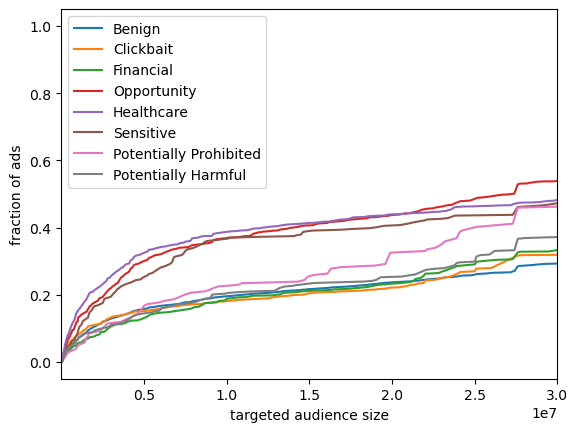

In [99]:
def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

for column in data.columns[:9]:
    if column == 'estimate_mau':
        continue
    a = np.sort(data.loc[(data[column]==1) & (data['estimate_mau'] >= 0), 'estimate_mau'])
    x, y = ecdf(a)
    
    plt.plot(x, y, label=column)
plt.legend()

plt.ylabel('fraction of ads')
plt.xlabel('targeted audience size')
#plt.xscale('log')
plt.xlim(1e3, 0.3e8)
    #plt.title(column)
    #plt.show()

In [50]:
# now let's find out what interests are the most popular in each category

In [52]:
import json
interests = json.loads(open('/home/piotr/interest_lookup.json').read())

In [94]:
from collections import defaultdict
use_counts = defaultdict(lambda: defaultdict(int))
import ast

totals = {code: data[code].sum() for code in data.columns}

for idx, row in targeting_params.iterrows():
    try:
        codes = adid_codes[row['adid']]
    except:
        continue
        
    if row['WAISTUIInterestsType'] is not None and type(row['WAISTUIInterestsType'])==str:
        for interest_id in ast.literal_eval(row['WAISTUIInterestsType'])['interest_ids']:
            for code in codes:
                try:
                    use_counts[code][interests[str(interest_id)]] += 1/totals[code]
                except:
                    continue
    else:
        for code in codes:
            use_counts[code]['None'] += 1/totals[code]
    

In [95]:
use_counts.keys()

dict_keys(['Benign', 'Opportunity', 'Healthcare', 'Clickbait', 'Study', 'Financial', 'Sensitive', 'CA Lawsuit', 'Political', 'Potentially Prohibited', 'Potentially Harmful', "Can't determine, return to this one", 'UNCAT'])

In [96]:
from operator import itemgetter
for code in use_counts:
    items = sorted(use_counts[code].items(), key=itemgetter(1), reverse=True)
    print(code)
    print(items[:10])
    print()

Benign
[('None', 0.7270378200611517), ('Online shopping', 0.0124970636598544), ('Health & wellness', 0.007892882311486979), ('Family', 0.006530420483908865), ('Physical fitness', 0.006530420483908865), ('Entertainment', 0.006389476156918025), ('Yoga', 0.006154568945266626), ('Dogs', 0.005966643175945507), ('Physical exercise', 0.0058726802912849475), ('Coupons', 0.004886070002349072)]

Opportunity
[('None', 0.6895338610378036), ('Higher education', 0.024626209322779216), ('Employment', 0.024626209322779216), ('Education', 0.023306948109058902), ('Technology', 0.016270888302550558), ('Career', 0.014511873350923472), ('Psychology', 0.013192612137203158), ('Job hunting', 0.012313104661389615), ('Personal development', 0.011873350923482844), ('Digital marketing', 0.011433597185576072)]

Healthcare
[('None', 0.7705355441204625), ('Health & wellness', 0.023632551934438712), ('Clinical trial', 0.021536115875738504), ('Physical fitness', 0.016580903373356194), ('Physical exercise', 0.014675052

In [82]:
use_counts['code'].items()

dict_items([])

In [114]:
data

,Benign,adid,estimate_mau,Clickbait,Financial,Opportunity,Healthcare,Sensitive,Potentially Prohibited,Potentially Harmful,Study,CA Lawsuit,Political,"Can't determine, return to this one",UNCAT
0,1.0,23849336815680703,1800000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,23848834321790690,256700000.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,23848832828510285,10700000.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,6242765307776,22100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,23849342920860340,2200000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32581,NaN,6298418662041,155800000.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32582,NaN,23850740455080331,6800000.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
32583,NaN,23849720664260612,85300000.0,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
32584,NaN,23849702408680621,244500000.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
# Usage of different targeting _types_ per ad category

from tqdm import tqdm


In [128]:
params_df = targeting_params.set_index('adid')
categories = ['Benign', 'Financial', 'Opportunity', 'Healthcare', 'Potentially Prohibited', 
              'Potentially Harmful', 'Clickbait', 'Sensitive']

In [190]:
usage_counter = defaultdict(lambda: defaultdict(int))
any_counter = defaultdict(int)
for idx, row in (tqdm(data.iterrows())):
    try:
        params = params_df.loc[row['adid']]
        used = []
        for k in params.keys():
            if k in ['adid', 'estimate_mau']: continue
            if not pd.isna(params[k]):
                used.append(k)
        if used == []:
            used = ['default']
            
        for category in row.keys():
            if category in ['adid', 'estimate_mau']: continue
            
            if not pd.isna(row[category]):
                any_counter[category] += 1
                for param in used:
                    usage_counter[category][param] += 1
    except:
        pass

32586it [00:12, 2515.65it/s]


In [165]:
parameters = ['age_min', 'age_max','gender', 'location', 'WAISTUILocaleType', 'WAISTUIInterestsType', 'WAISTUICustomAudienceType', 'default']

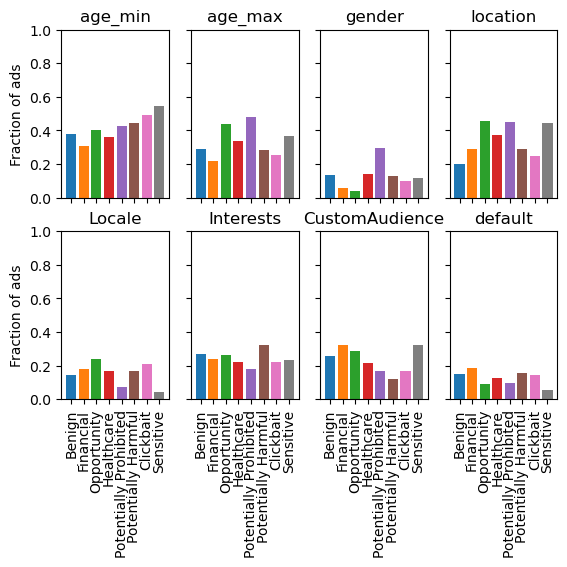

In [191]:
f, axes = plt.subplots(2, 4, sharey = True, sharex = True)
for pidx, parameter in enumerate(parameters):
    ax = axes[pidx//4, pidx%4]
    for cidx, category in enumerate(categories):
        try:
            frac = usage_counter[category][parameter] / any_counter[category]
        except:
            frac = 0
        ax.bar(cidx, frac)
    ax.set_title(parameter.replace('WAISTUI', '').replace('Type', ''))
    
    if pidx%4 == 0:
        ax.set_ylabel('Fraction of ads')
    if pidx//4 == 1:
        ax.set_xticks(range(0, len(categories)))
        ax.set_xticklabels(categories, rotation=90)
    ax.set_ylim(0, 1)

In [189]:
any_counter

defaultdict(int,
            {'Benign': 14405,
             'Clickbait': 14405,
             'Financial': 14405,
             'Opportunity': 14405,
             'Healthcare': 14405,
             'Sensitive': 14405,
             'Potentially Prohibited': 14405,
             'Potentially Harmful': 14405,
             'Study': 14405,
             'CA Lawsuit': 14405,
             'Political': 14405,
             "Can't determine, return to this one": 14405,
             'UNCAT': 14405})

In [ ]:
cccccbbnuggluvfnvferkbbehilvblccngd